# Moment Curvature Analysis of Section

In [16]:
import opstool as opst
import openseespy.opensees as ops
import matplotlib.pyplot as plt

## Create Section

.. Note::
    This step is not mandatory. 
    You can also use your own section, as the subsequent analysis only requires the section tag.

Note that you need to set the model to 6DOF in 3D, because the program takes two axes into account.

Create any opensees material yourself as follows:

In [10]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)

# materials
Ec = 3.55e7
Vc = 0.2
Gc = 0.5 * Ec / (1 + Vc)
fc = -32.4e3
ec = -2000.0e-6
ecu = 2.1 * ec
ft = 2.64e3
et = 107e-6
fccore = -40.6e3
eccore = -4079e-6
ecucore = -0.0144

Fys = 400.0e3
Fus = 530.0e3
Es = 2.0e8
eps_sh = 0.0074
eps_ult = 0.095
Esh = (Fus - Fys) / (eps_ult - eps_sh)
bs = 0.01

matTagC = 1
matTagCCore = 2
matTagS = 3
# for cover
ops.uniaxialMaterial("Concrete04", matTagC, fc, ec, ecu, Ec, ft, et)
# for core
ops.uniaxialMaterial("Concrete04", matTagCCore, fccore, eccore, ecucore, Ec, ft, et)
ops.uniaxialMaterial("ReinforcingSteel", matTagS, Fys, Fus, Es, Esh, eps_sh, eps_ult)

In [11]:
outlines = [[0, 0], [2, 0], [2, 2], [0, 2]]
coverlines = opst.pre.section.offset(outlines, d=0.05)
cover = opst.pre.section.create_polygon_patch(outlines, holes=[coverlines])
holelines = [[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]]
core = opst.pre.section.create_polygon_patch(coverlines, holes=[holelines])
SEC = opst.pre.section.FiberSecMesh()
SEC.add_patch_group(dict(cover=cover, core=core))
SEC.set_mesh_size(dict(cover=0.1, core=0.1))
SEC.set_mesh_color(dict(cover="gray", core="green"))
SEC.set_ops_mat_tag(dict(cover=matTagC, core=matTagCCore))
SEC.mesh()
# add rebars
rebar_lines = opst.pre.section.offset(outlines, d=0.05 + 0.032 / 2)
SEC.add_rebar_line(
    points=rebar_lines,
    dia=0.02,
    gap=0.1,
    color="red",
    ops_mat_tag=matTagS,
)
SEC.get_frame_props(display_results=False)
SEC.centring()
# sec.rotate(45)

OPSTOOL :: The section My Section has been successfully meshed!

Plot the section mesh:

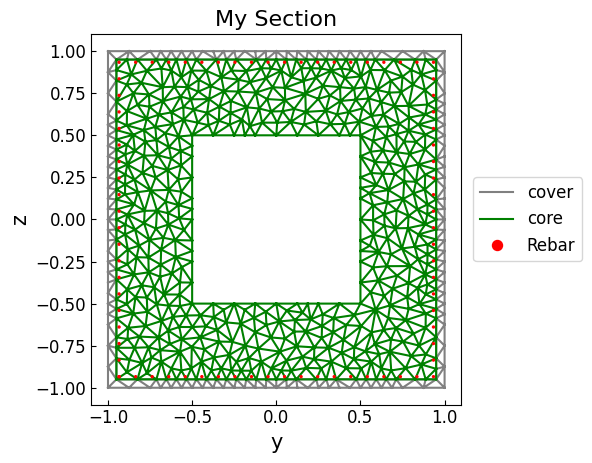

In [12]:
SEC.view(fill=False)

Generate the OpenSeesPy commands to the domin (important!)

In [13]:
sec_tag = 1
SEC.to_opspy_cmds(secTag=sec_tag, GJ=100000)

## Moment-curvature analysis

Now you can perform a moment-curvature analysis:

In [14]:
MC = opst.anlys.MomentCurvature(sec_tag=1, axial_force=-10000)
MC.analyze(axis="y", incr_phi=1e-4, limit_peak_ratio=0.8, smart_analyze=True)

> SmartAnalyze: Setting algorithm to  Newton ...

Plot the moment-curvature relationship:

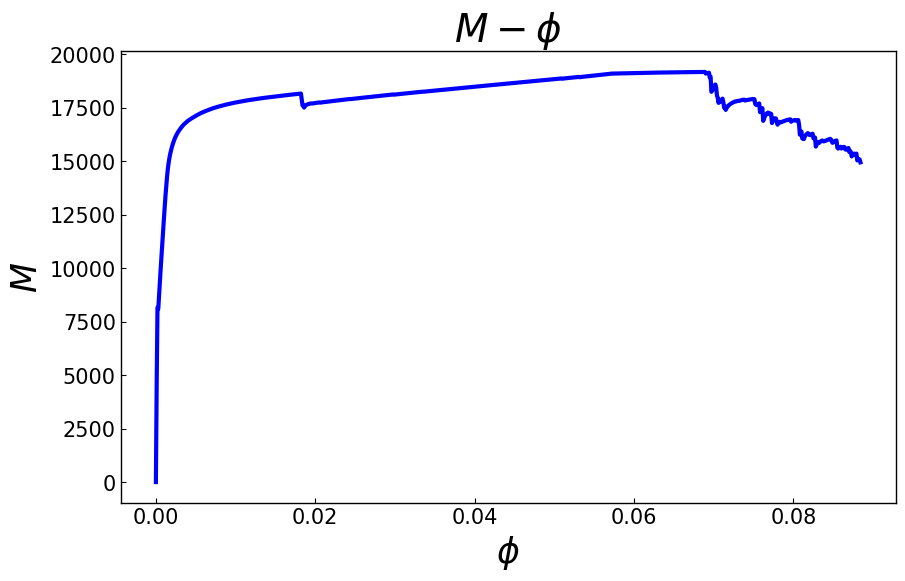

In [17]:
MC.plot_M_phi()
plt.show()

Plot all fiber stress-strain responses:

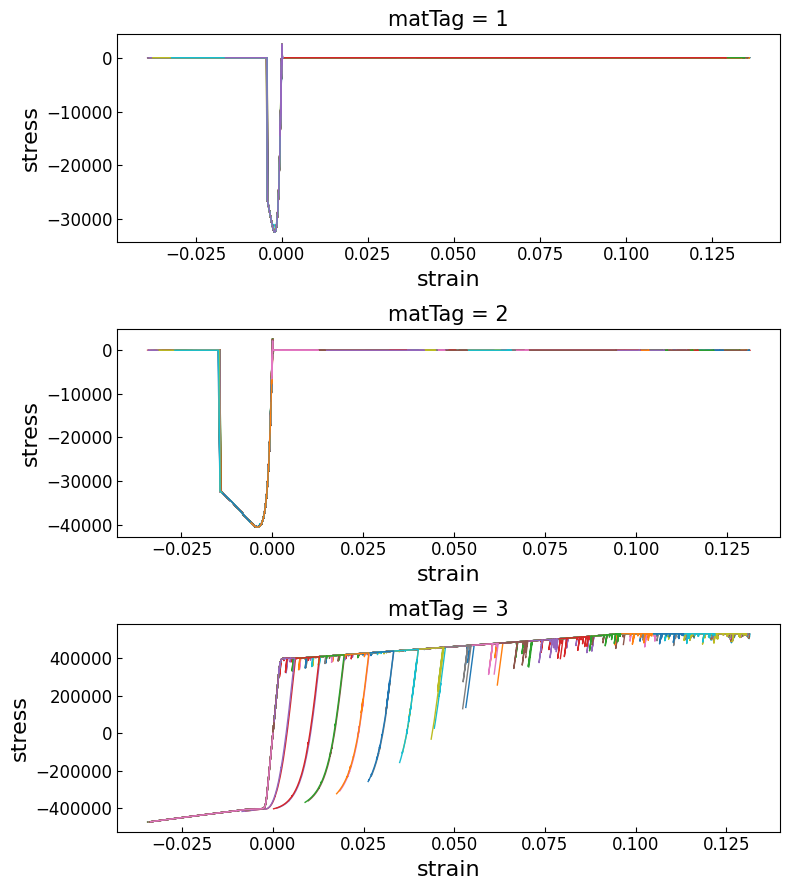

In [18]:
MC.plot_fiber_responses()
plt.show()

Extract limit state points based on fiber strain thresholds or other criteria.

In [21]:
# Tensile steel fibers yield (strain=2e-3) for the first time
phiy, My = MC.get_limit_state(
    matTag=matTagS,
    threshold=2e-3,
)
# The concrete fiber in the confined area reaches the ultimate compressive strain 0.0144
phiu, Mu = MC.get_limit_state(matTag=matTagCCore, threshold=-0.0144, peak_drop=False)
# or use peak_drop
# phiu, Mu = mc.get_limit_state(matTag=matTagCCore,
#                               threshold=-0.0144,
#                               peak_drop=0.2
#                              )

print(f"Limit state 1: phi_y={phiy:.4f}, My={My:.2f}")
print(f"Limit state 2: phi_u={phiu:.4f}, Mu={Mu:.2f}")

Limit state 1: phi_y=0.0015, My=14646.40
Limit state 2: phi_u=0.0690, Mu=19097.70


Equivalent linearization according to area:

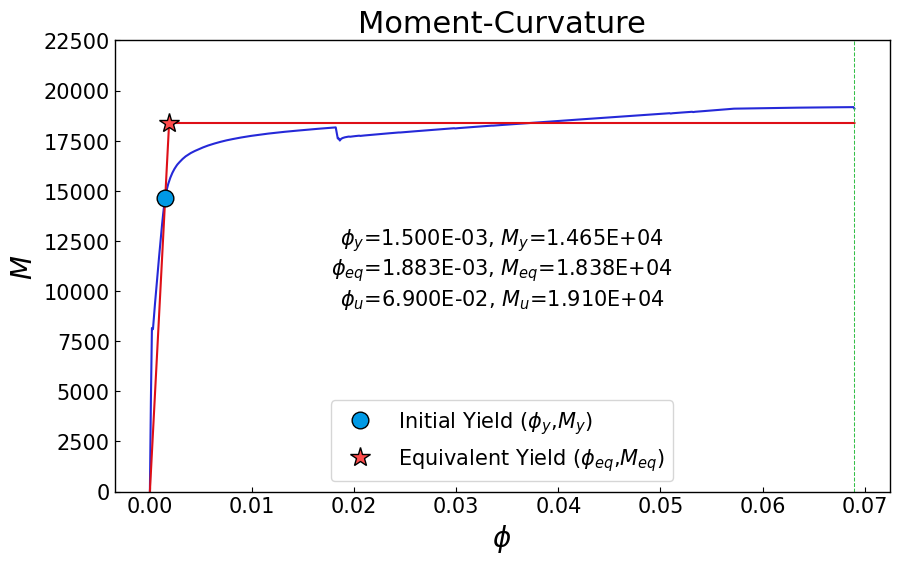

In [22]:
phi_eq, M_eq = MC.bilinearize(phiy, My, phiu, plot=True)
plt.show()